---
# **🍼👶🏻 Sistema di classificazione dei pianti neonatali: CNN + Transformer**
---
### 👩🏻👩🏻‍🦰 Beatrice & Giorgia

##⚙️ **SETUP**

1.   Installazione delle librerie necessarie
2.   Clonazione del dataset *Donate a Cry*
3.   Definizione dei parametri principali per l'addestramento del modello


In [ ]:
# Installazione delle dipendenze
!pip install --upgrade pip
!pip install librosa==0.9.2 audiomentations==0.27.0 torch torchvision torchaudio timm scikit-learn seaborn matplotlib

In [ ]:
# Clonazione del dataset "Donate a Cry" da GitHub
# Il dataset contiene registrazioni audio di pianti neonatali annotate con la causa del pianto
!git clone https://github.com/gveres/donateacry-corpus.git

fatal: destination path 'donateacry-corpus' already exists and is not an empty directory.


In [ ]:
# --- LIBRERIE ---

# Gestione file e operazioni di sistema
import os, random
from tqdm import tqdm

# Analisi e manipolazione dei dati
import numpy as np, pandas as pd

# Elaborazione audio
import librosa
import librosa.display # Import display explicitly

# Deep learning con PyTorch
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Strumenti per il training e la valutazione
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc

# Visualizzazione dei risultati
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from collections import defaultdict

# Data augmentation per segnali audio
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, ClippingDistortion, PolarityInversion

In [ ]:
# --- PARAMETRI ---

# Percorsi base del dataset
BASE_PATH = "donateacry-corpus"
DATA_PATH = os.path.join(BASE_PATH, "donateacry_corpus_cleaned_and_updated_data")

# Parametri audio
SR = 22050                     # Frequenza di campionamento
N_MELS = 64                    # Numero di bande Mel
N_FFT = 1024                   # Dimensione della finestra FFT
HOP_LENGTH = 256               # Passo tra finestre successive
DURATION = 7.0                 # Durata (in secondi) dei segmenti audio considerati
SAMPLES = int(SR * DURATION)   # Numero totale di campioni per clip
MAX_LEN_FRAMES = 320           # Lunghezza massima in frame dello spettrogramma

# Parametri di training
BATCH_SIZE = 8
NUM_EPOCHS = 30
SEED = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Impostazione del seed per garantire la riproducibilità dei risultati
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

## 📊 **DATASET**

1.   Esplorazione del dataset *Donate a Cry*
2.   Suddivisione in training, validation e test set
3.   Definizione delle trasformazioni di data augmentation per aumentare la variabilità dei dati audio durante l’addestramento

In [ ]:
# --- ESPLORAZIONE DEL DATASET ---

# Recupera i nomi delle classi (cartelle) presenti nel dataset
classes = sorted([d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))])

# Crea una mappatura tra etichette testuali e indici numerici
label2idx = {c: i for i, c in enumerate(classes)}
idx2label = {i: c for c, i in label2idx.items()}

print("Classi:", label2idx)

# Costruisce le liste dei percorsi ai file audio e delle relative etichette
file_paths, labels = [], []
for c in classes:
    folder = os.path.join(DATA_PATH, c)
    for f in os.listdir(folder):
        if f.lower().endswith('.wav'):
            file_paths.append(os.path.join(folder, f))
            labels.append(label2idx[c])

print("Tot files:", len(file_paths))
print(pd.Series(labels).value_counts())

Classi: {'belly_pain': 0, 'burping': 1, 'discomfort': 2, 'hungry': 3, 'tired': 4}
Tot files: 457
3    382
2     27
4     24
0     16
1      8
Name: count, dtype: int64


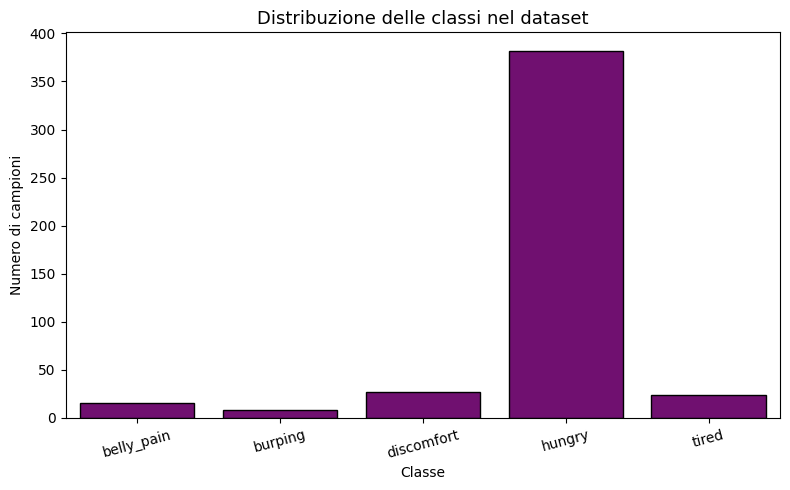

In [ ]:
# Crea una Serie pandas con le etichette numeriche
label_series = pd.Series(labels).map(idx2label)

plt.figure(figsize=(8, 5))
sns.countplot(x=label_series, color="purple", edgecolor="black")  # usa color invece di palette
plt.title("Distribuzione delle classi nel dataset", fontsize=13)
plt.xlabel("Classe")
plt.ylabel("Numero di campioni")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [ ]:
# Primo split: 10% dei dati usato come test set
train_val_files, test_files, train_val_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.10, stratify=labels, random_state=SEED
)

# Secondo split: validation set pari al 15% del totale
# Poiché viene calcolato sul 90% rimanente, usiamo 15/90 = 0.1667
train_files, val_files, train_labels, val_labels = train_test_split(
    train_val_files, train_val_labels, test_size=0.1667, stratify=train_val_labels, random_state=SEED
)

print("Train:", len(train_files), "Val:", len(val_files), "Test:", len(test_files))

Train: 342 Val: 69 Test: 46


In [ ]:
# --- AUGMENTATION ---

# Ogni trasformazione viene applicata con una certa probabilità p

augment_train = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.6),    # Rumore gaussiano
    TimeStretch(min_rate=0.85, max_rate=1.15, p=0.4),                     # Allungamento o accorciamento del segnale
    PitchShift(min_semitones=-1.5, max_semitones=1.5, p=0.5),             # Variazione dell’altezza tonale
    Shift(min_fraction=-0.2, max_fraction=0.2, p=0.4),                    # Spostamento temporale
    ClippingDistortion(max_percentile_threshold=10, p=0.15),              # Distorsione simulata
    PolarityInversion(p=0.05),                                            # Inversione di fase
])

## 🔊 **MEL**

1.   Calcolo dei log-mel spettrogrammi
2.   Applicazione delle trasformazioni di data augmentation
3.   Creazione dei dataser PyTorch (train, validation, test)
4.   Bilanciamento delle calssi tramite campionamento pesato

In [ ]:
# --- PRECOMPUTAZIONE DEI MEL ---

# Target di esempi per ciascuna classe
target_per_class = {
    'hungry': 400,
    'discomfort': 60,
    'tired': 60,
    'belly_pain': 60,
    'burping': 60
}

def precompute(files, labels, augment=None, prefix="train", target_per_class=None):
    out_files, out_labels = [], []

    # Raggruppa i file per classe
    files_per_class = defaultdict(list)
    for fp, lab in zip(files, labels):
        cls_name = idx2label[lab]
        files_per_class[cls_name].append((fp, lab))

    for cls_name, file_list in files_per_class.items():
        num_originals = len(file_list)
        target = target_per_class.get(cls_name, num_originals)
        n_aug_total = max(target - num_originals, 0)

        # Distribuisci gli augment in modo uniforme tra i file
        n_aug_per_file = [0] * num_originals
        for k in range(n_aug_total):
            n_aug_per_file[k % num_originals] += 1

        # Precompute
        for i, ((fp, lab), n_aug) in enumerate(zip(file_list, n_aug_per_file)):
            y, sr = librosa.load(fp, sr=SR)
            y = librosa.util.fix_length(y, size=SAMPLES)
            versions = [y]

            if augment:
                for _ in range(n_aug):
                    versions.append(augment(samples=y.copy(), sample_rate=SR))

            for j, v in enumerate(versions):
                melspec = librosa.feature.melspectrogram(y=v, sr=SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
                log_melspec = librosa.power_to_db(melspec, ref=np.max)
                log_melspec = np.pad(log_melspec, ((0,0),(0,max(0,MAX_LEN_FRAMES-log_melspec.shape[1]))), mode='constant')
                log_melspec = log_melspec[:, :MAX_LEN_FRAMES]

                # Create the directory if it doesn't exist
                os.makedirs("precomputed_mels", exist_ok=True)
                np.save(f"precomputed_mels/{prefix}_{cls_name}_{i}_{j}.npy", log_melspec.astype(np.float32))
                out_files.append(f"precomputed_mels/{prefix}_{cls_name}_{i}_{j}.npy")
                out_labels.append(lab)

    return out_files, out_labels

# Esecuzione della precomputazione per train, val e test
print("Precomputing train...")
train_files_pc, train_labels_pc = precompute(train_files, train_labels, augment_train, "train", target_per_class)
print("Precomputing val...")
val_files_pc, val_labels_pc = precompute(val_files, val_labels, None, "val", {})
print("Precomputing test...")
test_files_pc, test_labels_pc = precompute(test_files, test_labels, None, "test", {})

Precomputing train...


/usr/local/lib/python3.12/dist-packages/audiomentations/core/transforms_interface.py:57: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


Precomputing val...
Precomputing test...


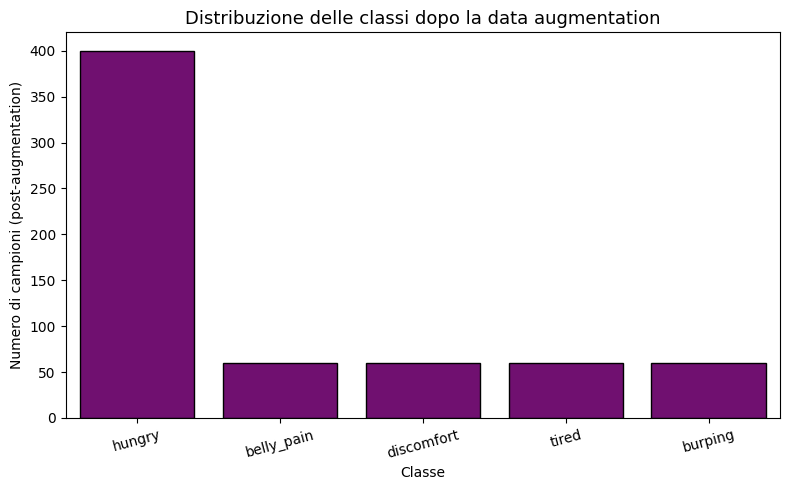

In [ ]:
# Distribuzione delle classi dopo l’augmentation
label_series_aug = pd.Series(train_labels_pc).map(idx2label)

plt.figure(figsize=(8, 5))
sns.countplot(x=label_series_aug, color="purple", edgecolor="black")
plt.title("Distribuzione delle classi dopo la data augmentation", fontsize=13)
plt.xlabel("Classe")
plt.ylabel("Numero di campioni (post-augmentation)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [ ]:
# --- DATASET ---

# Dataset PyTorch per i mel-spettrogrammi precomputati
class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files, self.labels = files, labels

    def __len__(self):
        # Ritorna la lunghezza del dataset
        return len(self.files)

    def __getitem__(self, idx):
        # Carica il mel-spettrogramma
        x = np.load(self.files[idx])
        # Normalizzazione (media 0, varianza 1)
        x = (x - x.mean()) / (x.std() + 1e-9)
        # Ritorna tensore (1 canale) + label
        return torch.tensor(x).unsqueeze(0), torch.tensor(self.labels[idx])

# Creazione dei dataset per training, validazione e test
train_ds = MelDataset(train_files_pc, train_labels_pc)
val_ds = MelDataset(val_files_pc, val_labels_pc)
test_ds = MelDataset(test_files_pc, test_labels_pc)

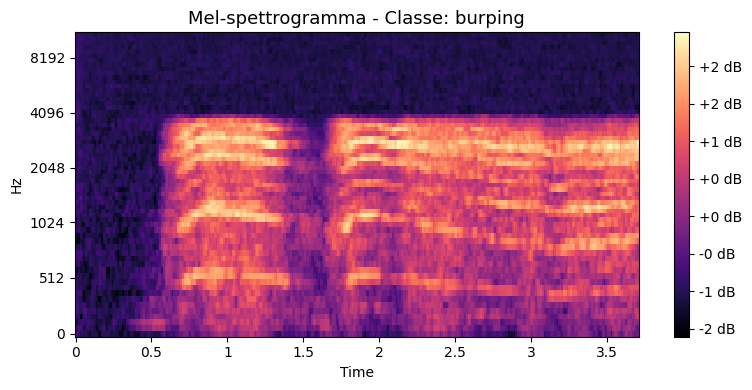

In [ ]:
#  Visualizzazione di un mel-spettrogramma di esempio

# Seleziona un indice casuale dal dataset di training
idx_example = np.random.randint(0, len(train_ds))
mel_tensor, label_tensor = train_ds[idx_example]

# Converti in numpy per la visualizzazione
mel = mel_tensor.squeeze(0).numpy()
label_name = idx2label[int(label_tensor)]

# Mostra il mel-spettrogramma
plt.figure(figsize=(8, 4))
librosa.display.specshow(mel, sr=SR, hop_length=HOP_LENGTH, x_axis="time", y_axis="mel", cmap="magma")
plt.title(f"Mel-spettrogramma - Classe: {label_name}", fontsize=13)
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

In [ ]:
# --- CAMPIONAMENTO PESATO ---

num_classes = len(classes)
# Conta quante istanze per classe
counts = np.bincount(train_labels_pc, minlength=num_classes)

# Calcola i pesi inversamente proporzionali alla frequenza delle classi
weights = 1. / (counts + 1e-9)
samples_weight = [weights[l] for l in train_labels_pc]

# Campionatore che seleziona in modo bilanciato
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

# DataLoader per training e test
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

## 🧠🏃‍➡️ **MODELLO E TRAIN**



1.   Definizione il modello CNN+Transformer per la classificazione dei pianti neonatali
2.   Visualizzazione di un esempio di input (mel-spettrogramma normalizzato)
3.   Training con monitoraggio di accuracy e F1-score, con early stopping e salvataggio del best model.

In [ ]:
# --- MODELLO ---

class CNNTransformer(nn.Module):
    def __init__(self, n_classes, in_ch=1, base_ch=16, n_heads=2, n_layers=1):
        super().__init__()
        # CNN: estrazione delle feature dai mel-spettrogrammi
        self.cnn = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 3, padding=1), nn.BatchNorm2d(base_ch), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(base_ch, base_ch*2, 3, padding=1), nn.BatchNorm2d(base_ch*2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(base_ch*2, base_ch*4, 3, padding=1), nn.BatchNorm2d(base_ch*4), nn.ReLU()
        )

        # Transformer Encoder
        d_model = base_ch*4
        layer = nn.TransformerEncoderLayer(d_model, n_heads, 256, 0.1, batch_first=True)
        self.transf = nn.TransformerEncoder(layer, num_layers=n_layers)

        # Classifier finale
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model//2, n_classes)
        )

    def forward(self, x):
        f = self.cnn(x)                            # estrai feature
        B,C,H,W = f.shape
        tok = f.permute(0,2,3,1).reshape(B,H*W,C)  # prepara tokens per il Transformer
        tok = self.transf(tok)                     # passa nel Transformer
        pooled = tok.mean(1)                       # pooling medio
        return self.fc(pooled)                     # classificazione finale

# Istanza del modello
model = CNNTransformer(n_classes=len(classes)).to(DEVICE)

# Funzione di loss e ottimizzatore
criterion = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=3)

In [ ]:
# --- TRAIN ---

def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            preds.extend(torch.argmax(out, 1).cpu().numpy())
            labels.extend(yb.cpu().numpy())

    return accuracy_score(labels, preds), f1_score(labels, preds, average='macro'), labels, preds

# Calcolo della loss media su un intero DataLoader
def compute_loss_on_loader(model, loader, criterion):

    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            losses.append(loss.item())
    return np.mean(losses)

# Liste per tracciare le metriche
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_errors, val_errors = [], []
val_f1s = []

best_f1, patience, counter = -1, 6, 0

print("\nINIZIO TRAINING\n")
for epoch in range(NUM_EPOCHS):
    model.train()
    tot_loss = 0
    preds_train, labels_train = [], []

    # ---- Training loop ----
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)
    for xb, yb in pbar:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        opt.step()
        tot_loss += loss.item()

        preds_train.extend(torch.argmax(out, 1).cpu().numpy())
        labels_train.extend(yb.cpu().numpy())

    # ---- Metriche di training ----
    train_loss = tot_loss / len(train_loader)
    train_acc = accuracy_score(labels_train, preds_train)
    train_error = 1 - train_acc

    # ---- Metriche di validazione ----
    val_acc, val_f1, val_labels, val_preds = evaluate(model, val_loader)
    val_loss = compute_loss_on_loader(model, val_loader, criterion)
    val_error = 1 - val_acc

    # ---- Aggiornamento liste per grafici ----
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_errors.append(train_error)
    val_errors.append(val_error)
    val_f1s.append(val_f1)

    scheduler.step(val_f1)

    # ---- Stampa riepilogo epoca ----
    print(f"\nEpoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Train Err: {train_error:.4f} | Val Err: {val_error:.4f} | Val F1: {val_f1:.4f}")

    # ---- Early stopping ----
    if val_f1 > best_f1:
        torch.save(model.state_dict(), "best_cnn_transformer_multiclass.pth")
        best_f1 = val_f1
        counter = 0
        print("best model salvato")
    else:
        counter += 1
        if counter >= patience:
            print("\nEarly stopping")
            break

print("\n TRAINING COMPLETATO\n")



INIZIO TRAINING




Epoch: 1/30 | Train Loss: 1.4293 | Val Loss: 1.3645 | Train Acc: 0.4062 | Val Acc: 0.5797 | Train Err: 0.5938 | Val Err: 0.4203 | Val F1: 0.1864
best model salvato



Epoch: 2/30 | Train Loss: 1.4309 | Val Loss: 1.3636 | Train Acc: 0.4047 | Val Acc: 0.6087 | Train Err: 0.5953 | Val Err: 0.3913 | Val F1: 0.2324
best model salvato



Epoch: 3/30 | Train Loss: 1.4024 | Val Loss: 1.4042 | Train Acc: 0.4109 | Val Acc: 0.4928 | Train Err: 0.5891 | Val Err: 0.5072 | Val F1: 0.1991



Epoch: 4/30 | Train Loss: 1.3997 | Val Loss: 1.3534 | Train Acc: 0.4141 | Val Acc: 0.6087 | Train Err: 0.5859 | Val Err: 0.3913 | Val F1: 0.2324



Epoch: 5/30 | Train Loss: 1.4052 | Val Loss: 1.3763 | Train Acc: 0.4297 | Val Acc: 0.5507 | Train Err: 0.5703 | Val Err: 0.4493 | Val F1: 0.1732



Epoch: 6/30 | Train Loss: 1.4101 | Val Loss: 1.3759 | Train Acc: 0.4203 | Val Acc: 0.5652 | Train Err: 0.5797 | Val Err: 0.4348 | Val F1: 0.2159



Epoch: 7/30 | Train Loss: 1.4196 | Val Loss: 1.3820 | Train Acc: 0.4297 | Val Acc: 0.5217 | Train Err: 0.5703 | Val Err: 0.4783 | Val F1: 0.2081



Epoch: 8/30 | Train Loss: 1.3981 | Val Loss: 1.3659 | Train Acc: 0.4172 | Val Acc: 0.5797 | Train Err: 0.5828 | Val Err: 0.4203 | Val F1: 0.2239

Early stopping

 TRAINING COMPLETATO



## 📉 **RISULTATI**


1.   Confusion matrix sia per la classificazione multiclasse sia per la classificazione binaria (hungry vs not hungry)
2.   Grafici come la distribuzione delle predizioni e ROC curve per il task binario

Multiclass Test Acc: 0.6086956521739131
Multiclass F1: 0.2183368869936034

Classification Report:

              precision    recall  f1-score   support

  belly_pain       0.20      0.50      0.29         2
     burping       0.00      0.00      0.00         1
  discomfort       0.00      0.00      0.00         3
      hungry       0.93      0.71      0.81        38
       tired       0.00      0.00      0.00         2

    accuracy                           0.61        46
   macro avg       0.23      0.24      0.22        46
weighted avg       0.78      0.61      0.68        46



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


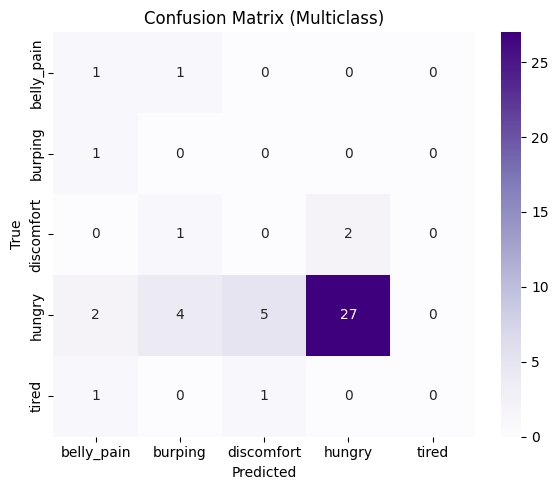

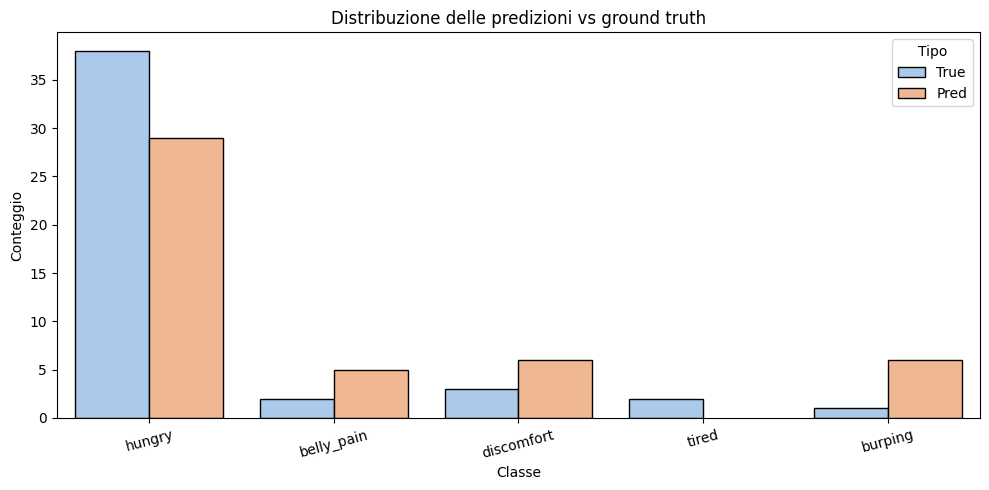

In [ ]:
# --- TEST MULTICLASSE ---

# Carica il miglior modello e valuta sul test set
model.load_state_dict(torch.load("best_cnn_transformer_multiclass.pth"))
test_acc, test_f1, y_true, y_pred = evaluate(model, test_loader)

print("Multiclass Test Acc:", test_acc)
print("Multiclass F1:", test_f1)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Purples', edgecolor='black')
plt.title("Confusion Matrix (Multiclass)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Prepara il DataFrame in formato "long" per seaborn
df = pd.DataFrame({
    "Classe": [idx2label[y] for y in y_true] + [idx2label[p] for p in y_pred],
    "Tipo": ["True"]*len(y_true) + ["Pred"]*len(y_pred)
})

plt.figure(figsize=(10,5))
sns.countplot(data=df, x="Classe", hue="Tipo", palette="pastel", edgecolor="black")
plt.title("Distribuzione delle predizioni vs ground truth")
plt.xlabel("Classe")
plt.ylabel("Conteggio")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Binary Results (hungry vs not hungry):
              precision    recall  f1-score   support

  not hungry       0.35      0.75      0.48         8
      hungry       0.93      0.71      0.81        38

    accuracy                           0.72        46
   macro avg       0.64      0.73      0.64        46
weighted avg       0.83      0.72      0.75        46



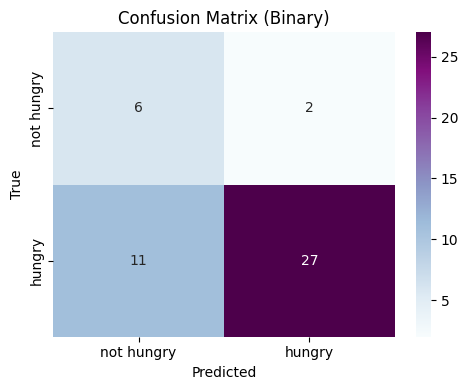

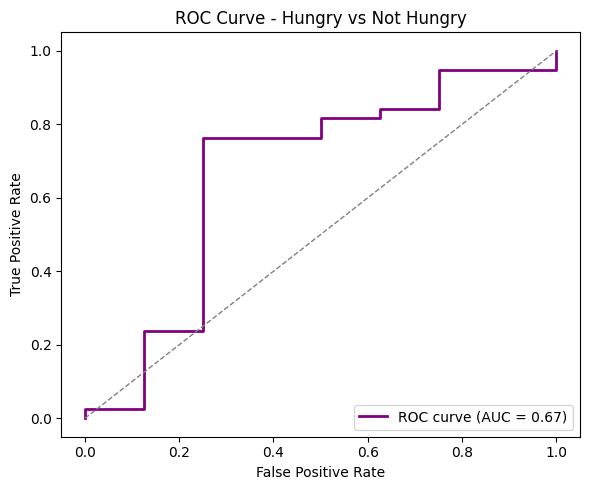

In [ ]:
# --- CONVERSIONE IN BINARIO: HUNGRY vs NOT HUNGRY ---

y_true_bin = [1 if idx2label[y]=="hungry" else 0 for y in y_true]
y_pred_bin = [1 if idx2label[p]=="hungry" else 0 for p in y_pred]

print("Binary Results (hungry vs not hungry):")
print(classification_report(y_true_bin, y_pred_bin, target_names=["not hungry","hungry"]))

# Confusion matrix binaria
cm_bin = confusion_matrix(y_true_bin, y_pred_bin)
plt.figure(figsize=(5,4))
sns.heatmap(cm_bin, annot=True, fmt='d', xticklabels=["not hungry","hungry"], yticklabels=["not hungry","hungry"], cmap='BuPu', edgecolor='black')
plt.title("Confusion Matrix (Binary)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC Curve e AUC
# Per ROC curve servono le probabilità, quindi calcoliamo softmax
model.eval()
probs = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        out = model(xb)
        probs.extend(torch.softmax(out, dim=1)[:, classes.index("hungry")].cpu().numpy())

fpr, tpr, thresholds = roc_curve(y_true_bin, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='grey', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Hungry vs Not Hungry")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

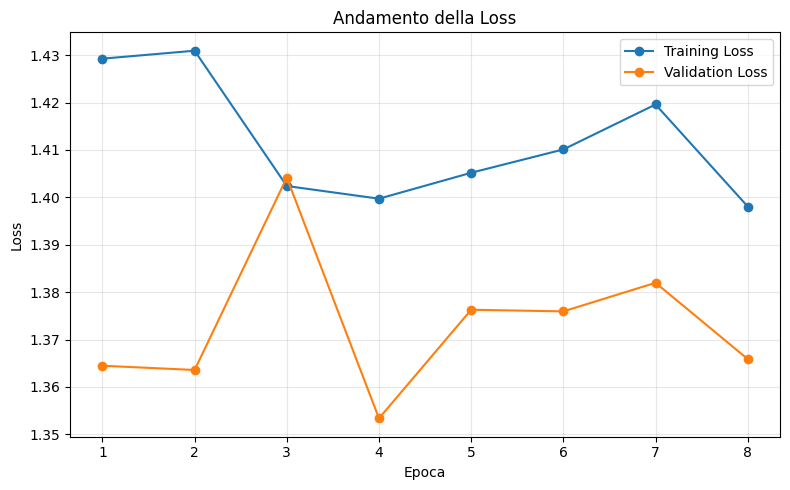

In [ ]:
# Andamento della Training e Validation Loss

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.title("Andamento della Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

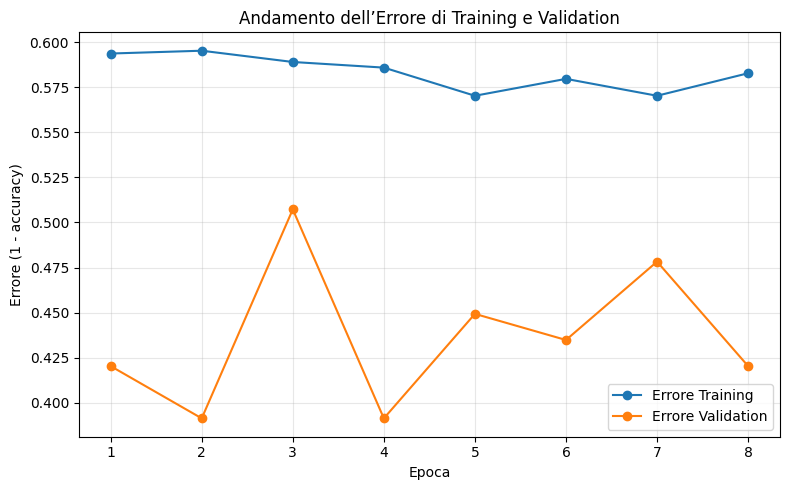

In [ ]:
# Andamento dell’Errore (1 - Accuracy)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_errors)+1), train_errors, label="Errore Training", marker='o')
plt.plot(range(1, len(val_errors)+1), val_errors, label="Errore Validation", marker='o')
plt.xlabel("Epoca")
plt.ylabel("Errore (1 - accuracy)")
plt.title("Andamento dell’Errore di Training e Validation")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

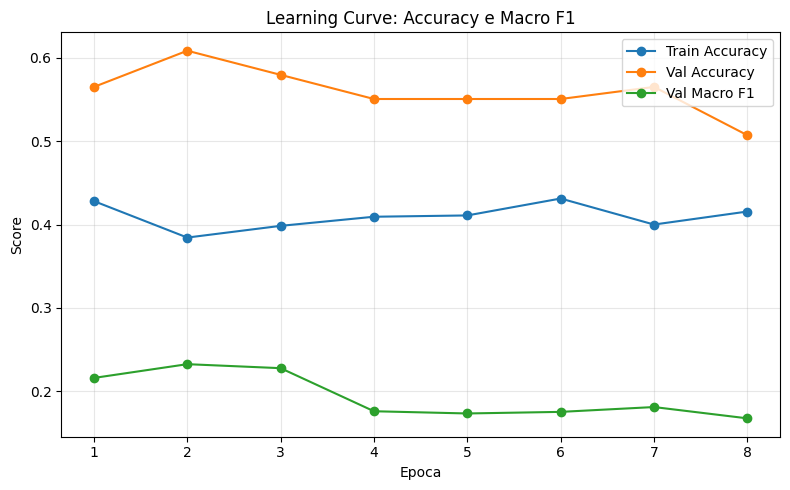

In [ ]:
# --- METRICHE PER OGNI EPOCA ---

# Ri-eseguo il training salvando metriche per ogni epoca
best_f1, patience, counter = -1, 6, 0
train_acc_list, val_acc_list = [], []
val_f1_list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    tot_loss = 0
    preds_train, labels_train = [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        opt.step()
        tot_loss += loss.item()
        preds_train.extend(torch.argmax(out, 1).cpu().numpy())
        labels_train.extend(yb.cpu().numpy())

    train_acc = accuracy_score(labels_train, preds_train)
    train_acc_list.append(train_acc)

    val_acc, val_f1, _, _ = evaluate(model, val_loader)
    val_acc_list.append(val_acc)
    val_f1_list.append(val_f1)

    scheduler.step(val_f1)

    if val_f1 > best_f1:
        torch.save(model.state_dict(),"best_cnn_transformer_multiclass.pth")
        best_f1 = val_f1
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            break

plt.figure(figsize=(8,5))
plt.plot(range(1,len(train_acc_list)+1), train_acc_list, label="Train Accuracy", marker='o')
plt.plot(range(1,len(val_acc_list)+1), val_acc_list, label="Val Accuracy", marker='o')
plt.plot(range(1,len(val_f1_list)+1), val_f1_list, label="Val Macro F1", marker='o')
plt.xlabel("Epoca")
plt.ylabel("Score")
plt.title("Learning Curve: Accuracy e Macro F1")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(range(1,len(train_acc_list)+1))
plt.tight_layout()
plt.show()